In [105]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import linregress
from matplotlib.patches import Rectangle
from plot import load_logs, plot_runs, add_values_from_normal_runs, PV_MAP
# refresh files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
def plot_data(data, secondary_color_at=None, secondary_color_legend_text="", override_insignificance=False):
    for df_name, df in data.items():
        print(df_name)
        pv = "age" if "age" in df_name else "sex"
        metrics = [col for col in df.columns if "subgroupAUROC" in col]
        df = df[["protected_attr", "protected_attr_percent", "seed"] + metrics]
        df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
        metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
        # g = plot_normal_runs(df, metrics, pv, figsize=(15, 9))
        print(df.protected_attr_percent.unique())
        g = plot_runs(df, metrics, pv, figsize=(12, 8), secondary_color_at=secondary_color_at, secondary_color_legend_text=secondary_color_legend_text, override_insignificance=override_insignificance)
        # save plot g to df_name and give it the name "subgroupAUROC"
        g.figure.savefig(f"{df_name}/subgroupAUROC.png")
        plt.show()

# Baseline

In [111]:
data = load_logs(log_dir = "../logs_final/normal")

../logs_final/normal/2023-09-02 22:38:35-FAE-rsna-age-bs32-noDP
[0.4  0.85 0.7  0.25 0.5  0.75 0.8  0.95 0.65 0.15 0.3  0.35 0.9  0.55
 0.2  0.1  0.6  0.   0.45 1.  ]
hello


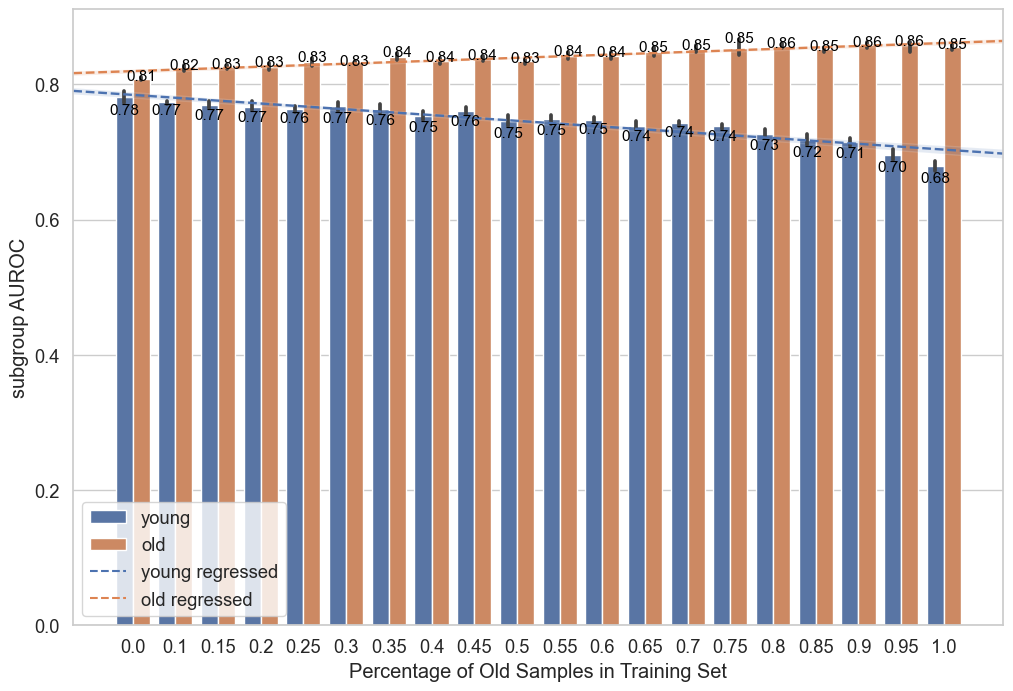

../logs_final/normal/2023-10-12 12:37:16-FAE-rsna-sex-bs512-DP-FINAL
[0.5  0.   1.   0.25 0.75]
hello


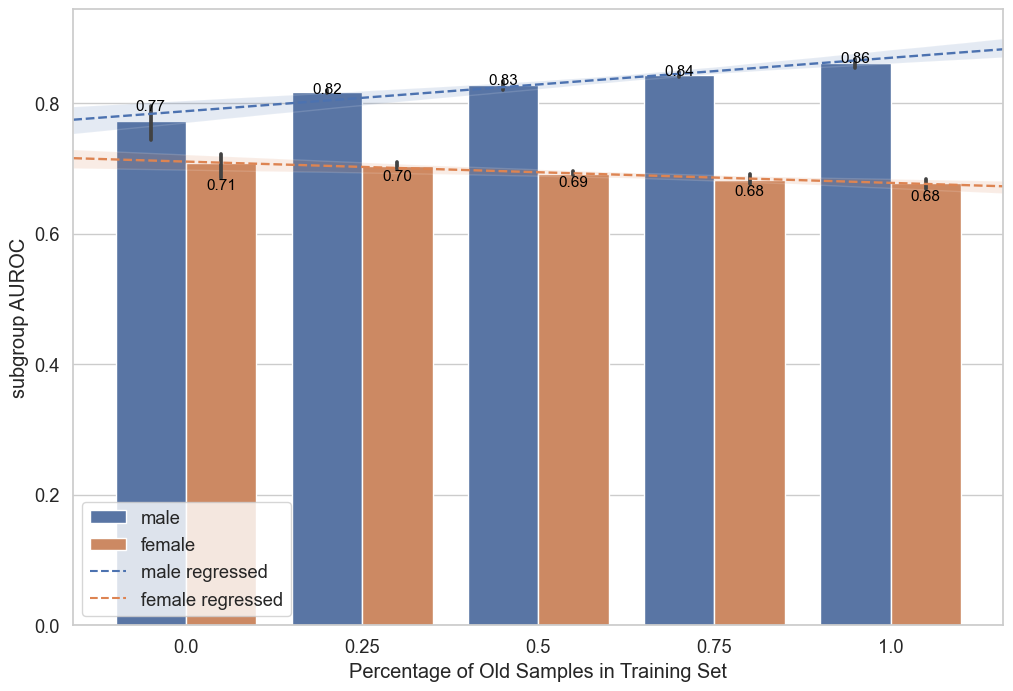

../logs_final/normal/2023-09-06 22:38:03-FAE-rsna-sex-bs32-noDP
[0.85 0.25 0.55 0.8  0.35 0.45 0.6  1.   0.75 0.65 0.2  0.7  0.   0.3
 0.4  0.95 0.1  0.5  0.15 0.9 ]
hello


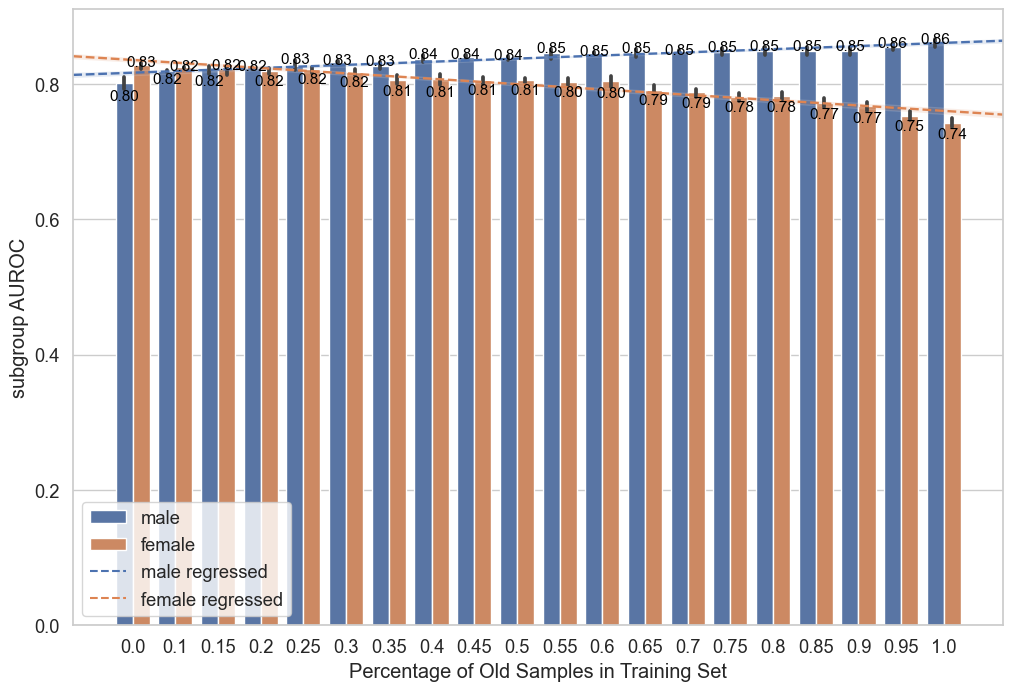

../logs_final/normal/2023-10-07 21:31:36-FAE-rsna-age-bs512-DP-FINAL
[1.   0.75 0.25 0.5  0.  ]
hello


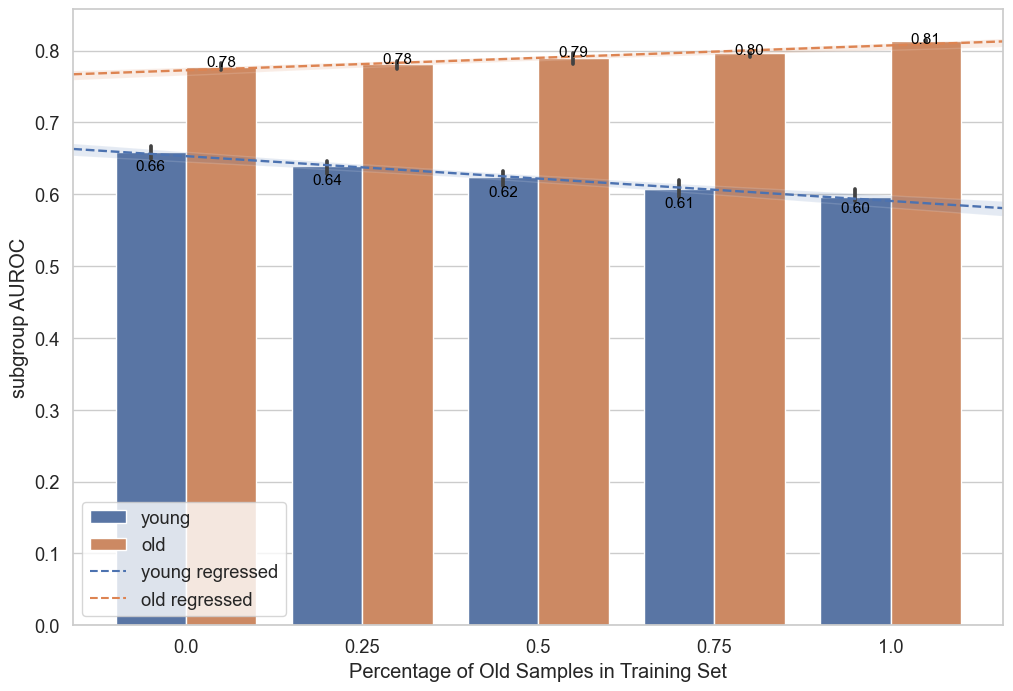

In [112]:
plot_data(data)

# Up-Sampling

In [ ]:
data = load_logs(log_dir = "../logs_final/upsampling")
data = add_values_from_normal_runs(data, 0.5)

In [ ]:
plot_data(data, secondary_color_at=0.5, secondary_color_legend_text="balanced - no upsampling")

# Loss Weighting

In [ ]:
data = load_logs(log_dir = "../logs_final/loss_weighing")

In [ ]:
def get_values_from_normal_runs(data_outer, split):
    data_normal = load_logs(log_dir = "../logs_final/normal")
    new_rows = {}
    for key, df_normal in data_normal.items():
        pv = "age" if "age" in key else "sex"
        dp = False if "noDP" in key else True
        corresponding_outer_keys = [k for k in data_outer.keys() if pv in k and ((not dp) == ("noDP" in k))]
        if corresponding_outer_keys == []:
            continue
        else:
            corresponding_outer_key = corresponding_outer_keys[0]
        rows = df_normal[df_normal["protected_attr_percent"] == split]
        new_rows[corresponding_outer_key] = rows
    return new_rows

In [ ]:
data_weight_1 = get_values_from_normal_runs(data, 0.5)
for key, dataset in data_weight_1.items():
    dataset["weight"] = 1
    data[key] = pd.concat([data[key], dataset])

In [ ]:
for key, dataset in data.items():
    dataset = dataset.loc[dataset["protected_attr_percent"] == 0.5]
    pv = "age" if "age" in key else "sex"
    metrics = [col for col in dataset.columns if "subgroupAUROC" in col]
    df = dataset[["protected_attr", "protected_attr_percent", "seed", "weight"] + metrics]
    # rename metrics
    df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
    metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
    plot_runs(
        df,
        metrics,
        pv,
        figsize=(12, 8),
        secondary_color_at=1.0,
        secondary_color_legend_text="no weighting",
        x_var="weight",
        regress=False
    )

# Fine-Tuning

In [107]:
data = load_logs(log_dir = "../logs_final/fine_tuning", fine_tuning=True)

../logs_final/fine_tuning/2023-10-23 00:13:58-FAE-rsna-sex-bs32-finetuning-noDP-FINAL
[0.25 0.8  0.6  1.   0.75 0.2  0.7  0.   0.3  0.4  0.1  0.5  0.9 ]
hello


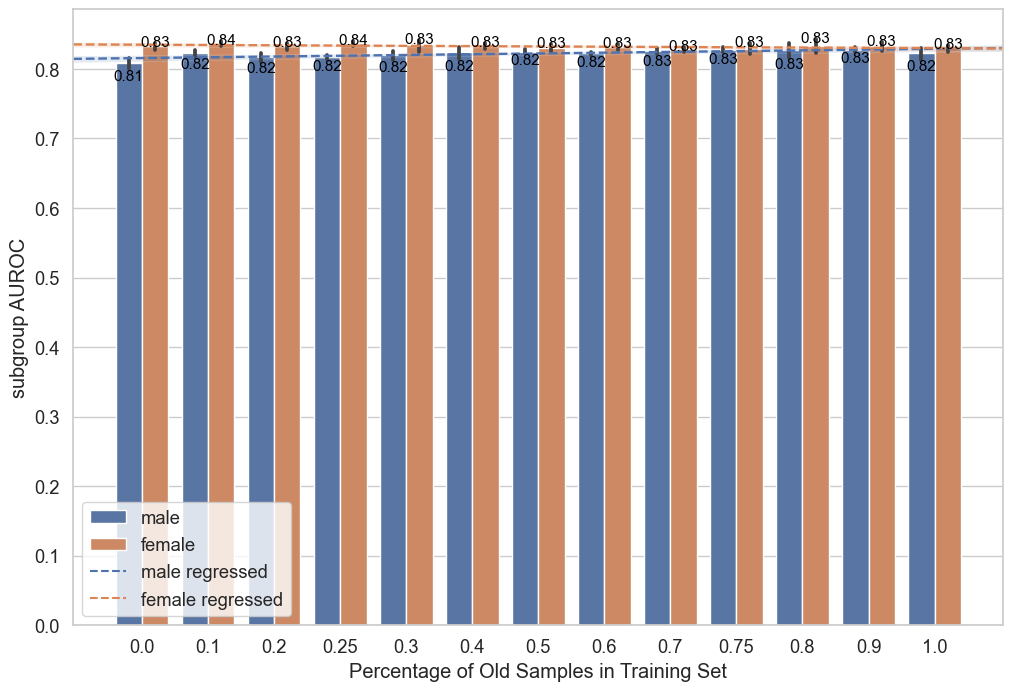

../logs_final/fine_tuning/2023-10-22 17:28:37-FAE-rsna-age-bs32-finetuning-noDP-FINAL
[0.4  0.7  0.25 0.5  0.75 0.8  0.3  0.9  0.2  0.1  0.6  0.   1.  ]
hello


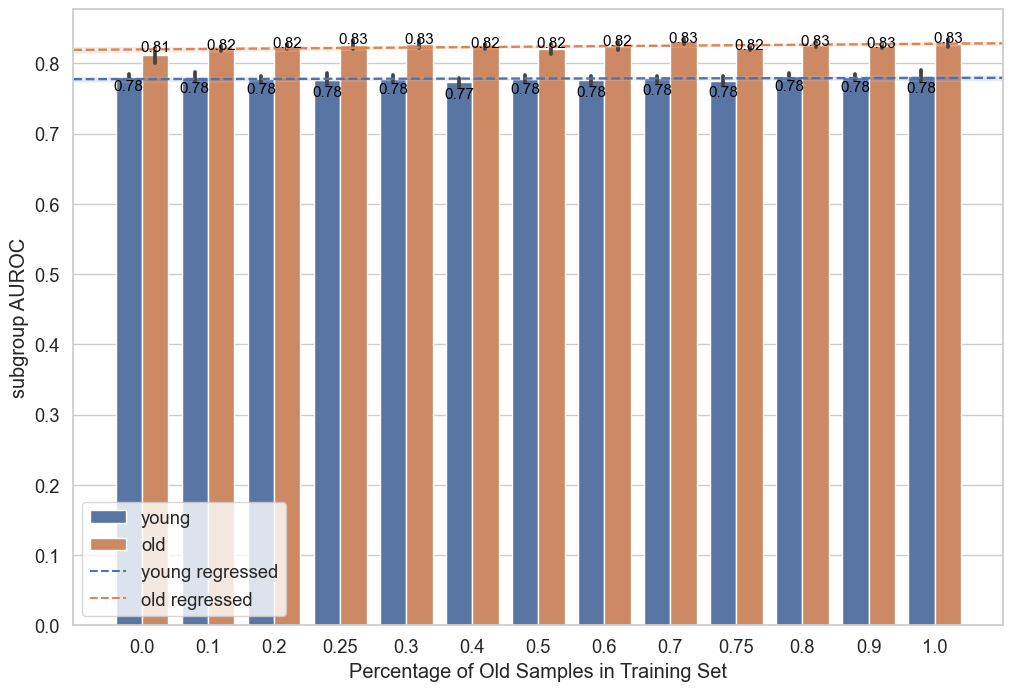

In [110]:
plot_data(data, override_insignificance=True)